# Imports and Function Definitions

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set()

import warnings
warnings.filterwarnings('ignore')
# from polygon import RESTClient

import datetime as dt

In [ ]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)
def ensemble_tree_feat_importance(m, df):
    feature_importances = np.mean([
    tree.feature_importances_ for tree in m.estimators_
                                    ], axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)
def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(15,20), legend=False)
def xgb_feat_importance(m, df):
    feature_importances = m.feature_importances_
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)

In [ ]:
def model_selection(ml):
    print(ml)
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3,1e-5,1e-7]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=25)
        grid = dict()
        grid['max_depth'] = [3,5,7,10]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25), n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                        ).fit(X_train, y_train)
    
    
    print(model_best)
    y_pred = model_best.predict(X_test)
    print('MAE: ', mean_absolute_error(y_pred, y_test), '\nMSE: ', mean_squared_error(y_pred,y_test), '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_pred)#, [X_train, X_test, y_train, y_test])

# Cleaning and Merging

In [713]:
client = RESTClient(api_key="18U85gkK04AWHrbE3oWvG9b3fF8JdlxQ")

In [714]:
vxx = client.get_aggs(ticker='VXX', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
spy = client.get_aggs(ticker='SPY', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
uso = client.get_aggs(ticker='USO', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)

In [695]:
poly_dict = {'vxx':vxx, 'spy':spy, 'uso':uso}

In [696]:
for data in poly_dict.keys():
    poly_dict[data] = pd.DataFrame(poly_dict[data])[['close', 'timestamp']]
    poly_dict[data] = poly_dict[data].rename(columns={'close':'Close', 'timestamp':'Local time'})
    poly_dict[data]['Local time'] = pd.to_datetime(poly_dict[data]['Local time'], unit='ms')

In [697]:
vxx = poly_dict['vxx']
spy = poly_dict['spy']
uso = poly_dict['uso']

In [18]:
fut = pd.read_csv('LIGHT.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
gas = pd.read_csv('GAS.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
btc = pd.read_csv('BTCUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
bond = pd.read_csv('USTBOND.TRUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')

In [19]:
data_dict = {'fut':fut, 'gas':gas, #'vxx':vxx, 'spy':spy, #'uso':uso, 
            'btc':btc, 'bond':bond}

## Datetime and indexing

In [20]:
# idx = pd.to_datetime(data_dict['fut']['Local time'])
# idx=idx.apply(lambda x: x.replace(tzinfo=None))

In [21]:
for data in data_dict.keys():
    if data in ['vxx', 'spy', 'uso']:
        data_dict[data] = data_dict[data].set_index(idx)
        data_dict[data] = data_dict[data].drop(['Open', 'High', 'Low', 'Volume', 'Local time'], axis=1)
    else:     
        ix = pd.to_datetime(data_dict[data]["Local time"].apply(lambda x: " ".join(x.split()[0:2])), format='%d.%m.%Y %H:%M:%S.%f')
        data_dict[data] = data_dict[data].set_index(ix)['Close']

## Merging

In [22]:
# df = pd.DataFrame(index=data_dict['vxx'].index)
df = pd.DataFrame(index=data_dict['fut'].index)
for data in data_dict.keys():
    df = pd.merge(df, data_dict[data], left_index=True, right_index=True, suffixes=['', '_'+data], how='left')
df = df.rename(columns={'Close':'Close_fut'})

## Cut to market hours

In [23]:
df['date'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').date(), axis=1)
df['time'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').time(), axis=1)

In [24]:
df = df.loc[ (df['time']>dt.time(7)) & (df['time']<dt.time(16)) ]
df = df[df.index.dayofweek < 5]

The plot below shows the high daily variance and the gaps between data are non-trading hours

In [25]:
df

,Close_fut,Close_gas,Close_btc,Close_bond,date,time
Local time,,,,,,
2020-02-11 07:05:00,50.445,1.7640,9801,162.280,2020-02-11,07:05:00
2020-02-11 07:10:00,50.375,1.7674,9815,162.311,2020-02-11,07:10:00
2020-02-11 07:15:00,50.326,1.7703,9816,162.248,2020-02-11,07:15:00
2020-02-11 07:20:00,50.356,1.7725,9821,162.561,2020-02-11,07:20:00
2020-02-11 07:25:00,50.445,1.7734,9816,162.401,2020-02-11,07:25:00
...,...,...,...,...,...,...
2023-02-10 15:35:00,79.799,2.5718,21531,126.899,2023-02-10,15:35:00
2023-02-10 15:40:00,79.779,2.5721,21487,126.899,2023-02-10,15:40:00
2023-02-10 15:45:00,79.764,2.5739,21552,126.901,2023-02-10,15:45:00


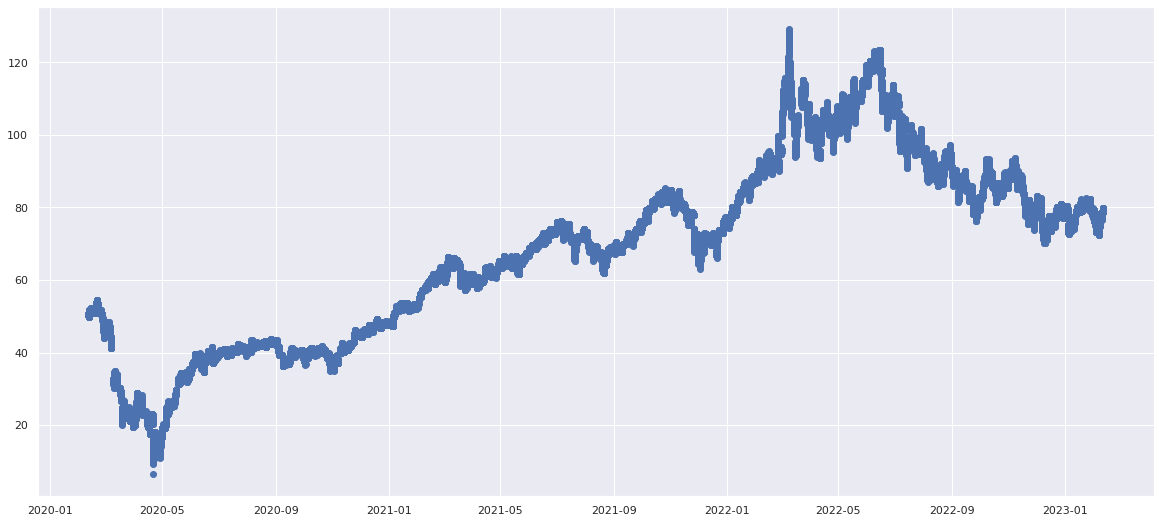

In [26]:
plt.subplots(figsize=(20,9))
plt.scatter(df.index, df['Close_fut'])

# Test Train Splits

## brainstorm:
2 train test splitting techniques: day by day or chunk by chunk.

- day by day: train p of the day test 1-p for each day, record accuracy for each day 
    - bad: small amount of data per train
    - good: consistent times predicted
- chunk by chunk: train n data points test m data points, record accuracy for each chunk
    - bad: inconsistent time predicted; different days have different vol levels and predicting across days could be problematic
    - good: more train data, could get different prediction horizons, no dependency on prediction time

## Day by Day

We split the data into individual days.  We calculate the $n$ period rolling standard deviation as our outcome measure within each day.  Then, we can concat the data together

In [27]:
days = list(set([d.date() for d in df.index]))

In [28]:
set(df.columns) - {'date', 'time'}

{'Close_bond', 'Close_btc', 'Close_fut', 'Close_gas'}

In [29]:
n=12
day_dict = {}
for day in days:
        
    day_dict[day] = df.loc[df['date'] == day]
    del day_dict[day]['date']
    
    for feat in set(df.columns) - {'date', 'time'}:
        day_dict[day][feat] = np.log( day_dict[day][feat] / day_dict[day][feat].shift(1) )
    
    day_dict[day][str(n)+'_oil_std'] = day_dict[day].rolling(n)['Close_fut'].std()
    day_dict[day] = day_dict[day][n:]

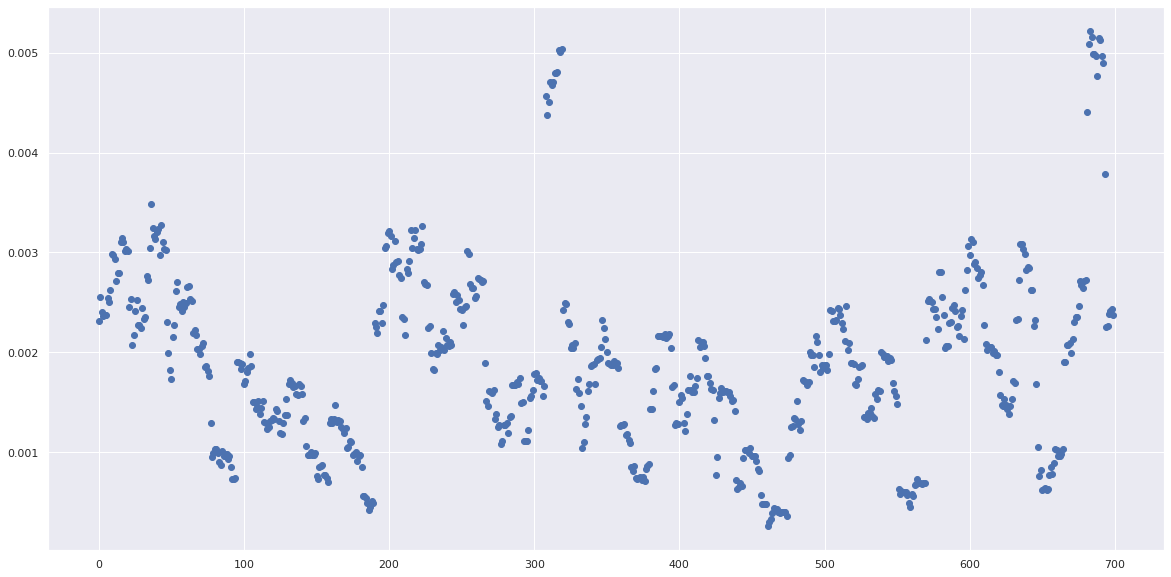

In [30]:
concat = pd.concat(day_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(700), concat[:700].reset_index(drop=True)[str(n)+'_oil_std'])

## Examining Temporal Structure

In [32]:
time_dist = concat.groupby('time')[str(n)+'_oil_std'].mean()

<AxesSubplot:xlabel='time'>

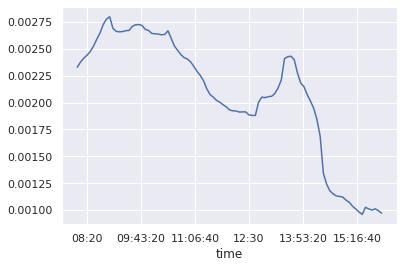

In [33]:
time_dist.plot()

The above plot shows that the trading volatility is clustered around the morning and roughly 2pm (historic oil desk close).  This is to be expected.  It will be important to strip times from the is dataset.

In [34]:
time_rets = concat.groupby('time')['Close_fut'].apply(lambda x: np.mean(abs(x)))

<AxesSubplot:xlabel='time'>

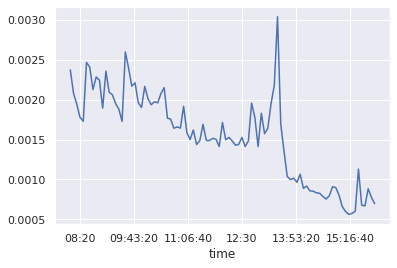

In [35]:
time_rets.plot()

Again we see the largest log returns concentrated around 1:30 pm

## Chunk by Chunk

In [36]:
len(days)

784

In [37]:
chunk_size = 1000

In [38]:
chunk_dict = {}

In [67]:
for i,chunk in df.groupby(np.arange(len(df)) // chunk_size):
    chunk_dict[i] = chunk.drop(['date', 'time'], axis=1)

In [68]:
chunk_indices = list(chunk_dict.keys())

In [69]:
len(chunk_indices)

84

In [70]:
from scipy import stats
from scipy.special import gamma
from math import ceil, sqrt

# Define the feature functions
# Some constants for feature creation
mu_1 = np.sqrt((2 / np.pi))
mu_43 = 2 ** (2 / 3) * gamma(7 / 6) * gamma(1 / 2) ** (-1)

# Since the data has not been resampled
M = 1

def rv(x):
    # Realized Variance (Andersen and Bollerslev, 1998)
    return (x ** 2).sum()

def rav(x):
    # Realized absolute variation (Forsberg and Ghysels, 2007)
    return mu_1 ** (-1) * M ** (-.5) * x.abs().sum()

def bv(x):
    # Realized bipower variation (Barndorff-Nielsen and Shephard; 2004, 2006)
    return mu_1 ** (-2) * (x.abs() * x.shift(1).abs()).sum()

def tq(x):
    # Standardized tri-power quarticity (see e.g. Forsberg & Ghysels, 2007)
    return M * mu_43 ** (-3) *(x.abs() ** (4 / 3) * x.shift(1).abs() ** (4 / 3) * 
                                x.shift(2).abs() ** (4 / 3)).sum()
    
def jump_test(x):
    # Jump test by Huang and Tauchen (2005)
    j = ((np.log(rv(x)+0.00000001) - np.log(bv(x)+0.00000001)) / \
        ((mu_1 ** -4 + 2 * mu_1 ** -2 - 5) / (M * tq(x) * bv(x) ** -2)) ** 0.5)

    jump = abs(j) >= stats.norm.ppf(0.999)
    
    return jump

def rv_m(x):
    # Realized Semivariance (Barndorff-Nielsen, Kinnebrock and Shephard, 2010)
    return((x ** 2 * (x < 0)).sum())

def rv_p(x):
    return((x ** 2 * (x > 0)).sum())

def sjv_p(x):
    # Signed jump variation (Patton and Sheppard, 2015)
    return((rv_p(x) - rv_m(x)) * (rv_p(x) - rv_m(x) > 0))

def sjv_m(x):
    # Signed jump variation (Patton and Sheppard, 2015)
    return((rv_p(x) - rv_m(x)) * (rv_p(x) - rv_m(x) < 0))

def rs(x):
    # Realized Skewness and Kurtosis  (see, e.g. Amaya, Christoffersen, Jacobs and Vasquez, 2015)
    return(np.sqrt(M) * (x ** 3).sum() / rv(x) ** (3 / 2))

def rk(x):
    return(M * (x ** 4).sum() / rv(x) ** 2)

In [71]:
%%time
n=12

for chunk in chunk_indices[:2]:    
    for feat in set(df.columns) - {'date', 'time'}:
        chunk_dict[chunk][feat] = np.log( chunk_dict[chunk][feat] / chunk_dict[chunk][feat].shift(1) )
        
    chunk_dict[chunk][str(n)+'_oil_std'] = chunk_dict[chunk].rolling(n)['Close_fut'].std()
    
    feat_funcs = [rv,rav,bv,tq,jump_test,rv_m,rv_p,sjv_p,sjv_m,rs,rk]

    for func in feat_funcs:
        # print(func)
        chunk_dict[chunk]["Fut_close_"+func.__name__] = chunk_dict[chunk]['Close_fut'].rolling(n).apply(func)#.shift(1)
    
    chunk_dict[chunk] = chunk_dict[chunk][n:]

CPU times: user 18.7 s, sys: 52.9 ms, total: 18.8 s
Wall time: 18.8 s


In [77]:
pd.concat(chunk_dict.values())['12_oil_std'][-20:]

Local time
2023-02-10 14:20:00   NaN
2023-02-10 14:25:00   NaN
2023-02-10 14:30:00   NaN
2023-02-10 14:35:00   NaN
2023-02-10 14:40:00   NaN
2023-02-10 14:45:00   NaN
2023-02-10 14:50:00   NaN
2023-02-10 14:55:00   NaN
2023-02-10 15:00:00   NaN
2023-02-10 15:05:00   NaN
2023-02-10 15:10:00   NaN
2023-02-10 15:15:00   NaN
2023-02-10 15:20:00   NaN
2023-02-10 15:25:00   NaN
2023-02-10 15:30:00   NaN
2023-02-10 15:35:00   NaN
2023-02-10 15:40:00   NaN
2023-02-10 15:45:00   NaN
2023-02-10 15:50:00   NaN
2023-02-10 15:55:00   NaN
Name: 12_oil_std, dtype: float64

In [20]:
concat = pd.concat(day_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(300), concat[:300].reset_index(drop=True)[str(n)+'_oil_std'])

NameError: name 'day_dict' is not defined

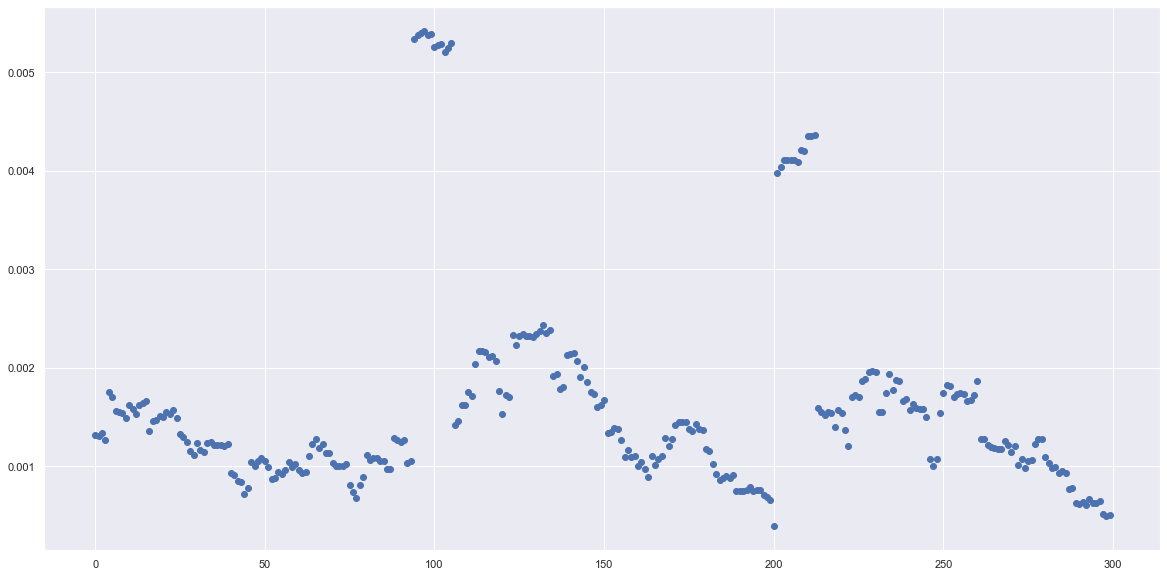

In [39]:
concat = pd.concat(chunk_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(300), concat[:300].reset_index(drop=True)[str(n)+'_oil_std'])

In [22]:
concat.to_csv('test_data.csv')

We can see the difference in splitting methods.  New days will appear as large jumps like this rather than smooth as in the day splitting.  

We might be able to fix this with some kind of smoothing technique ie windsorize and replace with some interpolation but it is probably best to just leave it be.  

# Predicting

We train on a fraction $p$ of each chunk and test on the remaining $1-p$ of the chunk.

In [2]:
df=pd.read_csv('test_data.csv')

In [3]:
df

,Local time,Close_fut,Close_gas,Close_btc,Close_bond,12_oil_std
0,2020-02-11 08:10:00,0.001783,0.000057,0.000610,-0.000191,0.001318
1,2020-02-11 08:15:00,0.001602,0.001810,0.000914,-0.000203,0.001308
2,2020-02-11 08:20:00,-0.000415,-0.000170,-0.000203,0.000424,0.001332
3,2020-02-11 08:25:00,0.000613,0.003836,-0.001016,0.000381,0.001264
4,2020-02-11 08:30:00,-0.003978,0.000675,-0.001730,0.000350,0.001754
...,...,...,...,...,...,...
82791,2023-02-10 15:35:00,0.000251,0.000000,-0.000696,-0.000252,0.000467
82792,2023-02-10 15:40:00,-0.000251,0.000117,-0.002046,0.000000,0.000418
82793,2023-02-10 15:45:00,-0.000188,0.000700,0.003021,0.000016,0.000419
82794,2023-02-10 15:50:00,-0.000313,-0.000700,-0.000696,0.000315,0.000422


We get a train test split for each chunk.

In [4]:
chunk_size = 1000
data_chunks = {}

for i,chunk in df.groupby(np.arange(len(df)) // chunk_size):
    total = chunk#.drop(['date', 'time'], axis=1)
    
    X = total[['Close_gas', 'Close_btc', 'Close_bond', 'Close_fut']]
    Y = total['12_oil_std']
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)
    
    data_chunks[i] = [X_train, X_test, y_train, y_test]

In [21]:
len(data_chunks)

83

## Predicting by chunk

In [7]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn_extensions.kernel_regression import KernelRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [14]:
# A bunch of nonparametric regression models + some parametric baselines
def model_selection(ml, data_list):
    X_train, X_test, y_train, y_test = data_list[0], data_list[1], data_list[2], data_list[3]
    print(ml)
    
    model_best = ''
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3] #1e-5,1e-7
        grid['n_estimators'] = [10] #50,100,1000
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=25)
        grid = dict()
        grid['max_depth'] = [3,5,7,10]
        grid['n_estimators'] = [10,50,100,1000]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\

                        ).fit(X_train, y_train)
    elif ml == 'AB':
        model = AdaBoostRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-4,1e-2,1]
        grid['n_estimators'] = [10,50,100,1000]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = AdaBoostRegressor(
                    learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                        ).fit(X_train, y_train)
          
    elif ml == 'KR':
        model = KernelRidge()
        grid = dict()
        grid['alpha'] = [1e-2,1e-1,1,10,100]
        grid["kernel"] = ["poly","sigmoid","rbf","cosine"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KernelRidge(alpha=grid_result.best_params_["alpha"],
                                 kernel=grid_result.best_params_["kernel"]).fit(X_train, y_train)
    elif ml == 'R':
        model = Ridge()
        grid = dict()
        grid['alpha'] = [1e-2,1e-1,1,10,100]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = Ridge(alpha=grid_result.best_params_["alpha"]).fit(X_train, y_train)
        
    elif ml == "LA":
        model = Lasso()
        grid = dict()
        grid['alpha'] = [1e-2,1e-1,1,10,100]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = Lasso(alpha=grid_result.best_params_["alpha"]).fit(X_train, y_train)
        
        
    elif ml == "EN":
        model = ElasticNet()
        grid = dict()
        grid['alpha'] = [1e-2,1e-1,1,10,100]
        grid["l1_ratio"] = [0.1,0.5,0.7,0.9,0.95]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = ElasticNet(alpha=grid_result.best_params_["alpha"],
                                l1_ratio = grid_result.best_params_["l1_ratio"]).fit(X_train, y_train)
    
    elif ml == "NW":
        # Bandwidth is selected automatically
        model = KernelRegression()
        grid = dict()
        grid["gamma"] = [1e-2, 1e-1, 1, 10,100]
        grid['kernel'] = ["rbf","poly"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KernelRegression(gamma=grid_result.best_params_["gamma"],
                            kernel = grid_result.best_params_["kernel"]).fit(X_train, y_train)
        
    elif ml == "KN":
        model = KNeighborsRegressor()
        grid = dict()
        grid["n_neighbors"] = [5,10,40,100]
        grid['weights'] = ["uniform","distance"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KNeighborsRegressor(n_neighbors=grid_result.best_params_["n_neighbors"],
                            weights = grid_result.best_params_["weights"]).fit(X_train, y_train)
        
    print(model_best)
    y_pred = model_best.predict(X_test)
    acc = {'MAE':mean_absolute_error(y_pred, y_test), 'MAPE':100 * mean_absolute_error(y_pred, y_test)/np.mean(y_test), 
           'MSE':mean_squared_error(y_pred,y_test), 'RMSE':np.sqrt(mean_squared_error(y_pred,y_test))}
    
    print('MAE: ', mean_absolute_error(y_pred, y_test), 
          'MAE%: ', 100 * mean_absolute_error(y_pred, y_test)/np.mean(y_test), 
          '\nMSE: ', mean_squared_error(y_pred,y_test), 
          '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_test, y_pred, acc)

In [28]:
%%time
chunk_results = {}
indices = data_chunks.keys()

indices = list(indices)

mod_list = ['GB', 'RF', 'AB', 'KR', 'R', 'LA', 'EN', 'NW', 'KN']

for i in indices:
    chunk_results[i] = {}
    for ml in mod_list:
        chunk_results[i][ml] = model_selection(ml, data_chunks[i])

GB
GradientBoostingRegressor(learning_rate=0.001, n_estimators=10)
MAE:  0.0016248453348858044 MAE%:  71.0922139123028 
MSE:  1.203730684869403e-05 
RMSE:  0.003469482216223918
RF
RandomForestRegressor(max_depth=5, n_estimators=50)
MAE:  0.0016013557556356383 MAE%:  70.06446920521647 
MSE:  1.1019371682631774e-05 
RMSE:  0.0033195438967773532
AB
AdaBoostRegressor(learning_rate=0.0001, n_estimators=10)
MAE:  0.0016108848830194656 MAE%:  70.48139920330533 
MSE:  1.1472161596396613e-05 
RMSE:  0.0033870579558662136
KR
KernelRidge(kernel='sigmoid')
MAE:  0.001624565522832463 MAE%:  71.07997123423105 
MSE:  1.2057180220618536e-05 
RMSE:  0.003472345060707322
R
Ridge(alpha=100)
MAE:  0.0016256337899889725 MAE%:  71.12671136116836 
MSE:  1.2053690638936768e-05 
RMSE:  0.0034718425423594266
LA
Lasso(alpha=0.01)
MAE:  0.001625633740295832 MAE%:  71.1267091869335 
MSE:  1.2053692058162298e-05 
RMSE:  0.003471842746750247
EN
ElasticNet(alpha=0.01, l1_ratio=0.1)
MAE:  0.001625633740295832 MAE%:  7

In [18]:
for label in chunk_results.keys():
    chunk_results[label]

In [68]:
acc_dict = {}
for chunk in chunk_results.keys():
    for m in mod_list:
        acc_dict[str(chunk)+m] = chunk_results[chunk][m][-1]
        acc_dict[str(chunk)+m]['model'] = m
        # acc_dict[m].append(m)

In [105]:
acc_df = pd.DataFrame(acc_dict).transpose()

In [106]:
acc_df

,MAE,MAPE,MSE,RMSE,model
0GB,0.00162485,71.0922,1.20373e-05,0.00346948,GB
0RF,0.00160136,70.0645,1.10194e-05,0.00331954,RF
0AB,0.00161088,70.4814,1.14722e-05,0.00338706,AB
0KR,0.00162457,71.08,1.20572e-05,0.00347235,KR
0R,0.00162563,71.1267,1.20537e-05,0.00347184,R
...,...,...,...,...,...
82R,0.000782065,72.4023,7.98161e-07,0.000893398,R
82LA,0.000782065,72.4023,7.98161e-07,0.000893399,LA
82EN,0.000782065,72.4023,7.98161e-07,0.000893399,EN
82NW,0.000781433,72.3437,7.96861e-07,0.000892671,NW


In [110]:
acc_df.reset_index(drop=True).groupby('model')['MAPE'].apply(lambda x: np.mean(x))

model
AB    48.717569
EN    53.630768
GB    53.547768
KN    46.353923
KR    53.546123
LA    53.630768
NW    53.408520
R     53.698022
RF    48.818487
Name: MAPE, dtype: float64

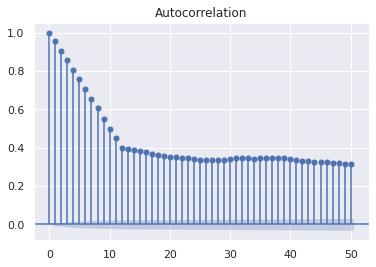

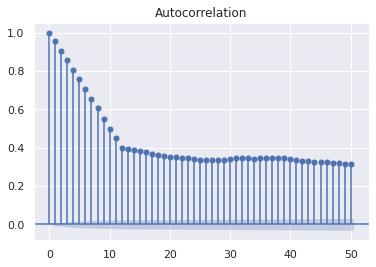

In [114]:
plot_acf(df['12_oil_std'])

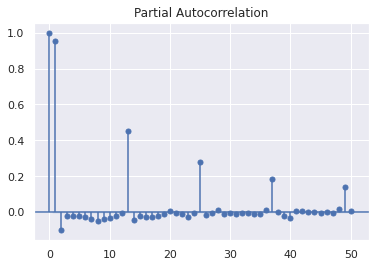

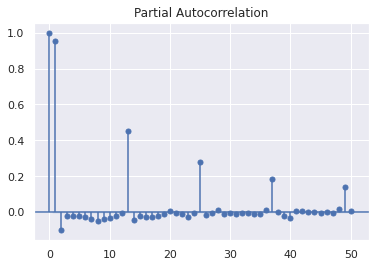

In [115]:
plot_pacf(df['12_oil_std'])